# Hardhat Detection with TensorFlow

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hardhat-and-safety-vest-image-for-object-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F434083%2F824685%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T062251Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D304266f14477f8d310eac2214165e54d4c609a2e56b57f64f48d4cc19b8fcaf7b452ee46b2d075d2d322736daf3e66f9bbbfc53d0c56aeb46522f72302f1dc07b582e3caa0d5ef73b2b9a02263d83fc9c9f40e8b79635a0d9f8787a33bc6ff59532690663e88a71d43b28940f62bdde1ddcf84e4031ce3b07316930969053e5a7a5dbce144ff38812e74865e7f6c8d9b47c52ab24a880425aaecfa472a4da87b50a1f6ca3e2d1eca076c465799125d6cafac196a13560ec9227f23dddc353b52dab7584ae6cf5f2fd7b21d04194ff6236d17dfe0a01db0c65ea9f3c7d2ca4bec7bf133a2d2255c13509bfad8366c0155ea672efb742bc2babc98c6199828fbe3,pretrained-trt-engines-cocotacohardhatposenet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1021278%2F1727884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T062251Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dda68db740f022d401e05aeb0d6a76976c4ba9d19e22a61156f2a2f0fe284afee6af60c66503d1f96accaf6cc8e2076c451c87557b5b0f267b28e74bb570deb4d391314b4472f0e53e48fb3647875c879623b3f136f2e970cffc53e95fda304c5bf1b34a0d33ad16e92b83d6a9e07de9267bc8dcfcd809c959ff3c82b49025f9fcf2d98cb10de4ed388710087c265d6675c0afa1765c0d1e32e527fbeb4a3e57df151c04a7bc36082b97551dba5fb35364121f71031e829d13dea45935e804ad6505c35b50a7320207a370d502e0878d074f1493c2a8f99302af0cc4cdf1a834775ac87780c9081518bdc33ccd78782357f2c7d00f628086e385b3175db1f80b3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


OSError: [WinError 1314] A required privilege is not held by the client: '/kaggle/input' -> '..\\input'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import os

In [3]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Cloning into 'models'...
remote: Enumerating objects: 96929, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 96929 (delta 78), reused 64 (delta 25), pack-reused 96720
Receiving objects: 100% (96929/96929), 611.07 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (70496/70496), done.

Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


In [4]:
!pip install object_detection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00


In [5]:
!pip install protobuf

In [6]:
!git clone https://github.com/tensorflow/models.git
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━

In [7]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [8]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [9]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=5)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

# Create LabelMap

In [10]:
categories = ["hardhat", "none"]
NCLASSES = 2

In [11]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = idx+1
    item.name = category

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "hardhat"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "none"\n',
 '  id: 2\n',
 '}\n']


In [12]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Reconstruct Frozen Graph

In [13]:
detection_graph = reconstruct("/kaggle/input/pretrained-trt-engines-cocotacohardhatposenet/base-models/ssd_mobilenet_v2_hardhat_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

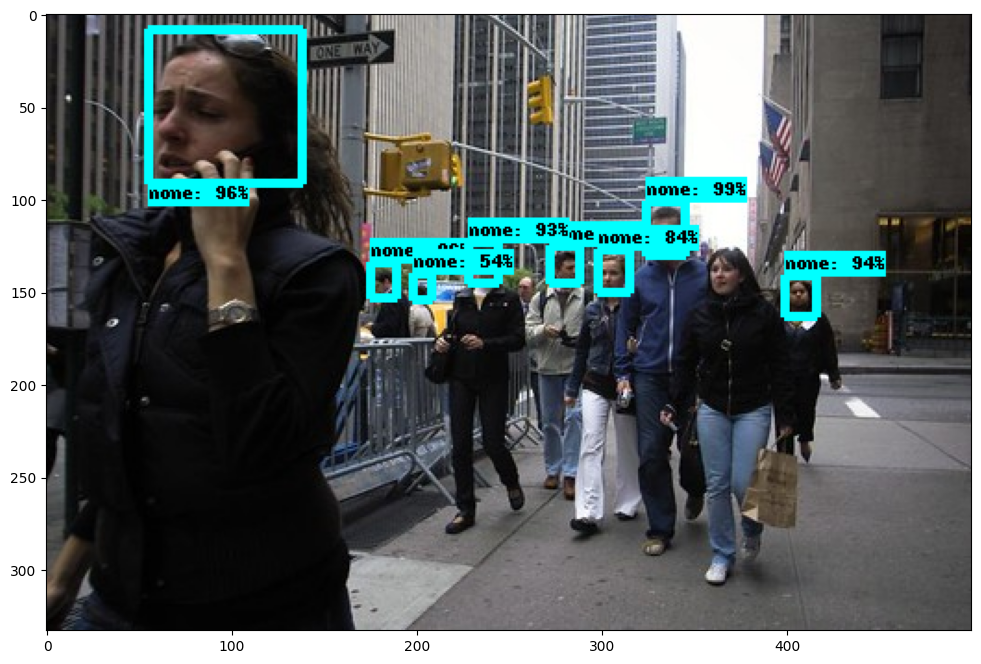

In [14]:
detect(detection_graph, '/kaggle/input/hardhat-and-safety-vest-image-for-object-detection/train/neg_100.jpg')

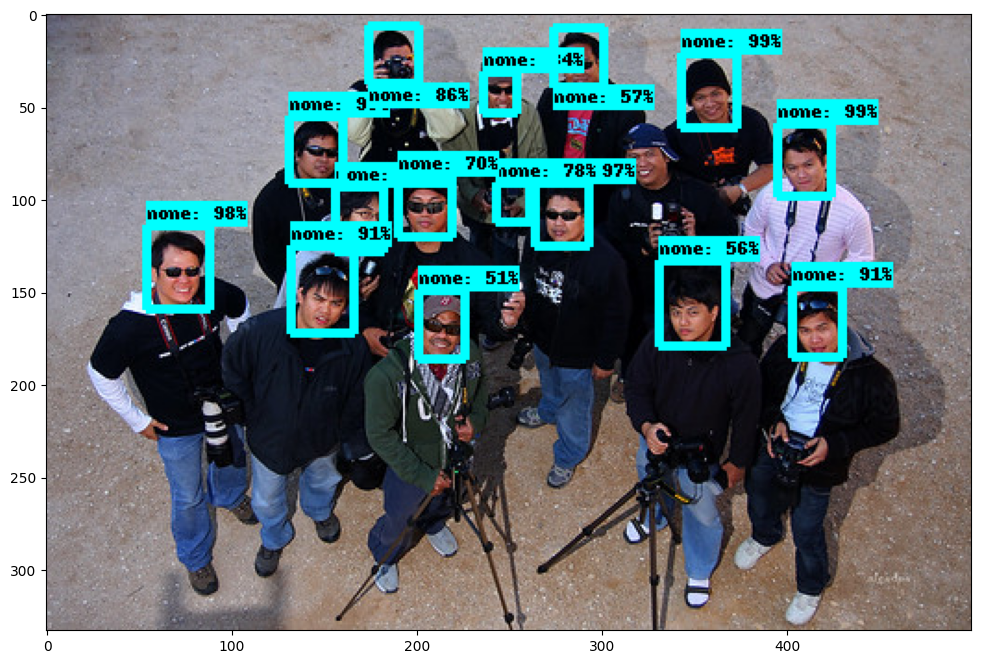

In [15]:
detect(detection_graph, '/kaggle/input/hardhat-and-safety-vest-image-for-object-detection/train/neg_1099.jpg')

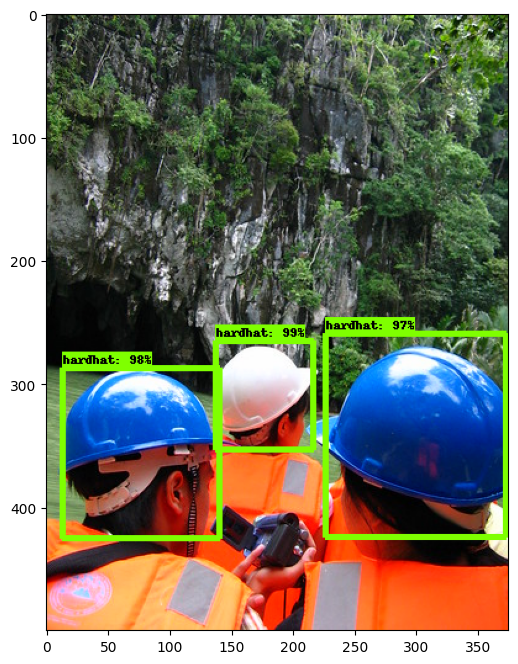

In [16]:
detect(detection_graph, '/kaggle/input/hardhat-and-safety-vest-image-for-object-detection/train/pos_942.jpg')

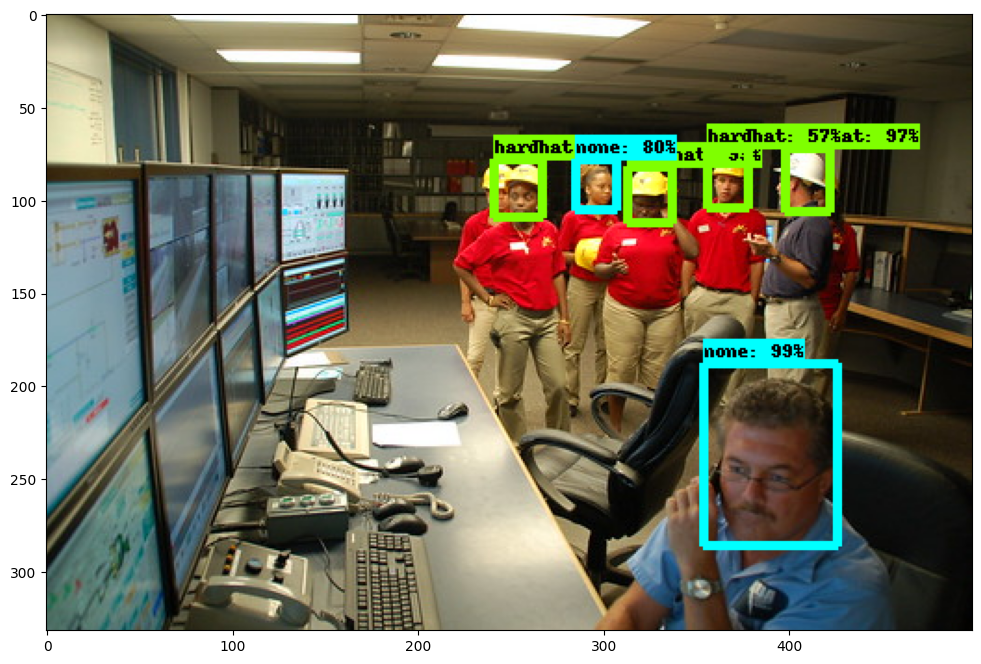

In [17]:
detect(detection_graph, '/kaggle/input/hardhat-and-safety-vest-image-for-object-detection/train/pos_971.jpg')

# Cleanup

In [18]:
! rm -rf ./models

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'construction-site-safety-image-dataset-roboflow:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2919095%2F5048288%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T123241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcaa5efaa6bdb106d138322321299072125f4a5c5962f7da0fed154d2d70095e15c3e2c8bd3db65aca4c56123327116fd4bc20f9679292163457fac8bbbb1b417005b8b9f9a8cdbee23bce90ff4fff59fde91dd56a63af911bedf59952f6b2ee8797afbcea2a20cd4b3b9fe3e19502a8c985b5473465d87319459d46b6e120e14521b62747d241e76f7c055be4afa94d3f59e4feb616f1f6b2542213d6e528a72dd7747beb20425cc3b696efdfb6a7ea6ed878be89f6a4716bb5f7378db3d0c228968fd2be9c38db2eff05dfbd924a8058096e0ac680261bc38bdefd223052a8c052892d4e900325e884ab4b39d1f47dde1726c06907cf68fa311d17a54a6a3ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


OSError: [WinError 1314] A required privilege is not held by the client: '/kaggle/input' -> '..\\input'

In [5]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Data path
data_path = 'C:\\Users\\allen\\Downloads\\imgdset\\css-data'
# Train, Valid and Test path
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')
# For saving results
output_path = '/kaggle/working'
# We can access both images and labels
folders = ['images', 'labels']
print("Data Path: {}\nTrain Path: {}\nValid Path: {}\nTest Path: {}\nOutput Path: {}".format(data_path, train_path, valid_path, test_path, output_path))

Data Path: C:\Users\allen\Downloads\imgdset\css-data
Train Path: C:\Users\allen\Downloads\imgdset\css-data\train
Valid Path: C:\Users\allen\Downloads\imgdset\css-data\valid
Test Path: C:\Users\allen\Downloads\imgdset\css-data\test
Output Path: /kaggle/working


In [58]:
# Initialize dictionaries of training and classes
train_dict = dict(train=0, valid=1, test=2)
path_dict = [train_path, valid_path, test_path]
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
class_dict = dict(zip(range(len(class_names)), class_names))
print(class_dict)

{0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [59]:
## Get filenames and labels information
# Sorting the filenames will make the labels and images in same order
train_filenames = sorted(os.listdir(os.path.join(train_path, folders[0])))
valid_filenames = sorted(os.listdir(os.path.join(valid_path, folders[0])))
test_filenames = sorted(os.listdir(os.path.join(test_path, folders[0])))
train_labels = sorted(os.listdir(os.path.join(train_path, folders[1])))
valid_labels = sorted(os.listdir(os.path.join(valid_path, folders[1])))
test_labels = sorted(os.listdir(os.path.join(test_path, folders[1])))

In [60]:
## One liner for the above code
# We can also use list comprehension for this
t_f, v_f, te_f = [sorted(os.listdir(os.path.join(path_dict[i], folders[0]))) for i in range(len(path_dict))]
t_l, v_l, te_l = [sorted(os.listdir(os.path.join(path_dict[i], folders[1]))) for i in range(len(path_dict))]

In [61]:
# Check whether both gives same results in filenames
train_filenames==t_f, valid_filenames==v_f, test_filenames==te_f

(True, True, True)

In [62]:
# Check whether both gives same results in labels

train_labels==t_l, valid_labels==v_l, test_labels==te_l

(True, True, True)

In [63]:
# Return lengths of all filenames
print("Total Train Files: {}\nTotal Valid Files: {}\nTotal Test Files:{}".format(len(train_filenames), len(valid_filenames), len(test_filenames)))

Total Train Files: 2605
Total Valid Files: 114
Total Test Files:82


In [64]:
# Check whether filenames and labels are of same length
len(train_filenames)==len(train_labels), len(valid_filenames)==len(valid_labels), len(test_filenames)==len(test_labels)

(True, True, True)

In [65]:
# Check order in filenames and labels in all splits
[item.split('.')[0] for item in train_filenames]==[item.split('.')[0] for item in train_labels],\
[item.split('.')[0] for item in valid_filenames]==[item.split('.')[0] for item in valid_labels],\
[item.split('.')[0] for item in test_filenames]==[item.split('.')[0] for item in test_labels]

(True, True, True)

In [66]:
set(train_filenames).intersection(set(valid_filenames)),\
set(valid_filenames).intersection(set(test_filenames)),\
set(test_filenames).intersection(set(train_filenames))

(set(), set(), set())

In [67]:
df = pd.DataFrame()
df['filenames'] = train_filenames + valid_filenames + test_filenames
df['labelnames'] = train_labels + valid_labels + test_labels
df['train_id'] = [0]*len(train_filenames) + [1]*len(valid_filenames) + [2]*len(test_filenames)

In [68]:
# No duplicate entries found
df.filenames.duplicated().value_counts()

filenames
False    2801
Name: count, dtype: int64

In [69]:
# Count of train valid and test sets
df.train_id.value_counts()

train_id
0    2605
1     114
2      82
Name: count, dtype: int64

In [70]:
train_keys = list(train_dict.keys())


In [71]:
# Complete path for annotation_files
annotation_files = (data_path + '/' + df.train_id.map(lambda x: train_keys[x]) + '/' + folders[1]
                    + '/' + df.labelnames).tolist()
t_id = df.train_id.tolist()
counts = []
invalid_idx = []
is_annotated = []
for idx, annotation_file in tqdm.tqdm(enumerate(annotation_files)):
    annotation = np.loadtxt(annotation_file)
    if len(annotation)==0:
        invalid_idx.append(idx)
        is_annotated.append(-1)
        counts.append([])
        continue
    if len(annotation.shape)==1:
        annotation = annotation.reshape(1, -1)
    counts.append(annotation[:,0].astype(int))
    is_annotated.append(1)
df['is_annotated'] = is_annotated

2801it [00:02, 1058.59it/s]


In [72]:
df.is_annotated.value_counts()

is_annotated
 1    2777
-1      24
Name: count, dtype: int64

In [73]:
# Create a count_dict which holds class counts per split (train/valid/test)
count_list = [np.unique(item, return_counts = True) for item in counts]
count_keys = [item[0] for item in count_list]
count_values = [item[1] for item in count_list]
count_dict = []
for ck,cv in zip(count_keys, count_values):
    count_dict.append(dict([(key,value) for key, value in zip(ck,cv)]))
df['count_dict'] = count_dict
df.head()

filenames  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...   

                                          labelnames  train_id  is_annotated  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...         0             1   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...         0             1   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...         0             1   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...         0             1   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...         0             1   

                                   count_dict  
0              {0: 2, 1: 2, 2: 2, 3: 2, 5: 4}  
1              {0: 2, 3: 2, 4: 4, 5: 9, 7: 2}  
2              {0: 1, 2: 1, 4: 2, 5: 2, 8: 2}  
3              {0: 3, 3: 3, 4: 3, 5: 7, 8: 6}  
4  {0: 2, 2: 1, 3: 3, 4: 2, 5: 6, 7: 1, 8: 5}

In [74]:
from collections import Counter
train_count = df[df.train_id==0].count_dict.apply(lambda x: Counter(x)).sum()
valid_count = df[df.train_id==1].count_dict.apply(lambda x: Counter(x)).sum()
test_count = df[df.train_id==2].count_dict.apply(lambda x: Counter(x)).sum()

In [75]:
df_count = pd.DataFrame()
df_count = pd.DataFrame({'train':train_count, 'valid': valid_count, 'test': test_count}).sort_index()
df_count

train  valid  test
0   3145     79   110
1   1651     21    28
2   2317     69    41
3   3097     74    79
4   3962    106    90
5   9532    166   174
6   3366     44    92
7   3033     41    61
8   5247     55    44
9   1545     42    41

In [76]:
df_count.to_csv('count.csv', index = False)

In [77]:
# Normalized Counts
df_count.train = df_count.train.apply(lambda x: x/df_count.train.sum())
df_count.valid = df_count.valid.apply(lambda x: x/df_count.valid.sum())
df_count.test = df_count.test.apply(lambda x: x/df_count.test.sum())
df_count

train     valid      test
0  0.085242  0.113343  0.144737
1  0.044749  0.030129  0.036842
2  0.062800  0.098996  0.053947
3  0.083941  0.106169  0.103947
4  0.107386  0.152080  0.118421
5  0.258355  0.238164  0.228947
6  0.091232  0.063128  0.121053
7  0.082206  0.058824  0.080263
8  0.142214  0.078910  0.057895
9  0.041876  0.060258  0.053947

In [78]:
df.to_csv('metadata.csv', index = False)

In [79]:
def yolo_annotation_to_bbox(annotation, img_height, img_width):
    """
    Converts Yolo annotations to bounding box coordinates
    Input:
    annotation: str, annotation file in .txt format
    img_height: int, image height
    img_width: int, image width
    Output:
    class: list, List of labels in the image
    bbox_list: list, List of bounding boxes in an image
    """
    sh = annotation.shape
    if len(sh)==0:
        print("No bounding box found")
    if len(sh)==1:
        annotation = annotation.reshape(1, -1)
    num_bbox = len(annotation)
    bbox_list = []
    for idx in range(num_bbox):
        c_x, c_y, w, h = annotation[idx][1:]
        x1 = ((c_x - w/2)*img_width).astype(int)
        x2 = ((c_x + w/2)*img_width).astype(int)
        y1 = ((c_y - h/2)*img_height).astype(int)
        y2 = ((c_y + h/2)*img_height).astype(int)
        bbox_list.append([x1, y1, x2, y2])
    return bbox_list

In [80]:
from telegram import Bot
import requests

# Your Telegram Bot Token
def alert(l):
    token ='7091226766:AAFXsC0bNQiGBclfYduG1iQrRUh7YgDp4KM'
    chat_id='1960529010'
    # Initialize Telegram Bot
    message='Alert!!!!Wear safety gear immediately!!!!'+l
    url = f"https://api.telegram.org/bot{token}/sendMessage?chat_id={chat_id}&text={message}"
    r=requests.get(url)
    print(r.json())



In [81]:
### invalid_files = (data_path + '/' + df.train_id[invalid_idx].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[invalid_idx])
invalid_files = df.filenames[invalid_idx]
def visualize_samples(mode = 'train', n_samples =12):
    """
    Plots 'n_samples' plots from train/valid/test split
    Input:
    mode: 'str' can take values from 'train'/'valid','test'
    n_samples: 'int'
    """
    # We will visualize only those files which have annotations
    indices = df[(~df.filenames.isin(invalid_files))&(df.train_id==1)].sample(n_samples).index
    filenames = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[indices]).tolist()
    annotations = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[1] + '/' + df.labelnames[indices]).tolist()
    plt.figure(figsize = (25, 25))
    plt.title('{} Set Samples'.format(mode.upper()))
    for idx in range(len(filenames)):
        image = np.array(Image.open(filenames[idx]))
        height, width, _ = image.shape
        annotation = np.loadtxt(annotations[idx])
        bbox_list = yolo_annotation_to_bbox(annotation, height, width)
        if len(annotation.shape)==1:
            annotation = annotation.reshape(1, -1)
        labels = [class_dict[item] for item in annotation[:,0].astype(int)]
        plt.subplot(4, 3, idx + 1)
        for label, bbox in zip(labels, bbox_list):
            if label=='NO-Mask' or label=='NO-Safety Vest' or label=='NO-Hardhat':
                #print(label)
                alert(label)
            x1, y1, x2, y2 = bbox
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

{'ok': True, 'result': {'message_id': 300, 'from': {'id': 7091226766, 'is_bot': True, 'first_name': 'SafetyGear', 'username': 'safety_gear_bot'}, 'chat': {'id': 1960529010, 'first_name': 'Allen', 'last_name': 'Roy', 'type': 'private'}, 'date': 1712937130, 'text': 'Alert!!!!Wear safety gear immediately!!!!NO-Safety Vest'}}
{'ok': True, 'result': {'message_id': 301, 'from': {'id': 7091226766, 'is_bot': True, 'first_name': 'SafetyGear', 'username': 'safety_gear_bot'}, 'chat': {'id': 1960529010, 'first_name': 'Allen', 'last_name': 'Roy', 'type': 'private'}, 'date': 1712937132, 'text': 'Alert!!!!Wear safety gear immediately!!!!NO-Safety Vest'}}
{'ok': True, 'result': {'message_id': 302, 'from': {'id': 7091226766, 'is_bot': True, 'first_name': 'SafetyGear', 'username': 'safety_gear_bot'}, 'chat': {'id': 1960529010, 'first_name': 'Allen', 'last_name': 'Roy', 'type': 'private'}, 'date': 1712937136, 'text': 'Alert!!!!Wear safety gear immediately!!!!NO-Safety Vest'}}
{'ok': True, 'result': {'mes

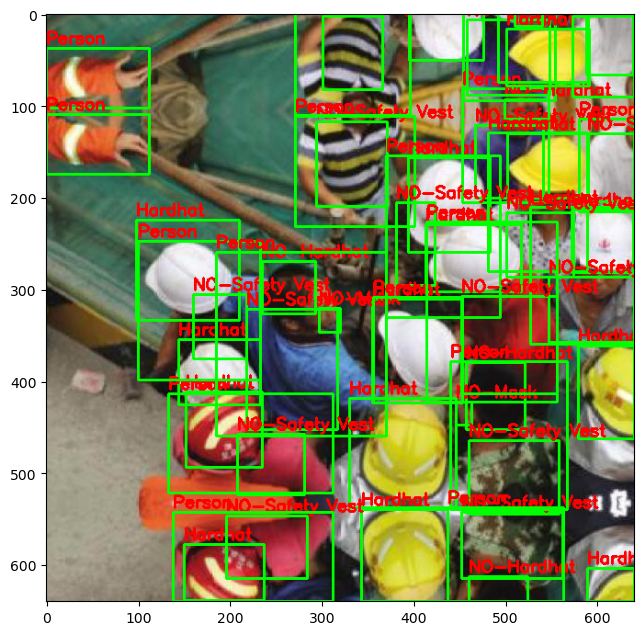

In [87]:
visualize_samples(mode = 'train', n_samples = 1)

{'ok': True, 'result': {'message_id': 323, 'from': {'id': 7091226766, 'is_bot': True, 'first_name': 'SafetyGear', 'username': 'safety_gear_bot'}, 'chat': {'id': 1960529010, 'first_name': 'Allen', 'last_name': 'Roy', 'type': 'private'}, 'date': 1712937313, 'text': 'Alert!!!!Wear safety gear immediately!!!!NO-Hardhat'}}
{'ok': True, 'result': {'message_id': 324, 'from': {'id': 7091226766, 'is_bot': True, 'first_name': 'SafetyGear', 'username': 'safety_gear_bot'}, 'chat': {'id': 1960529010, 'first_name': 'Allen', 'last_name': 'Roy', 'type': 'private'}, 'date': 1712937315, 'text': 'Alert!!!!Wear safety gear immediately!!!!NO-Safety Vest'}}


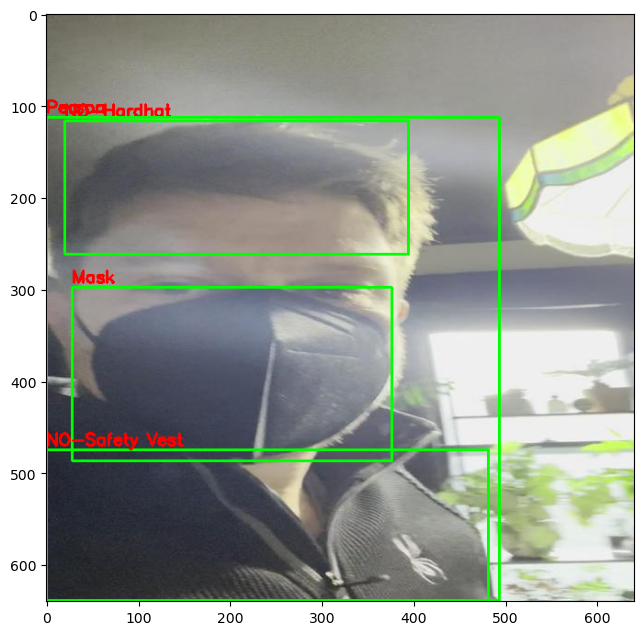

In [89]:
visualize_samples(mode = 'valid', n_samples = 1)

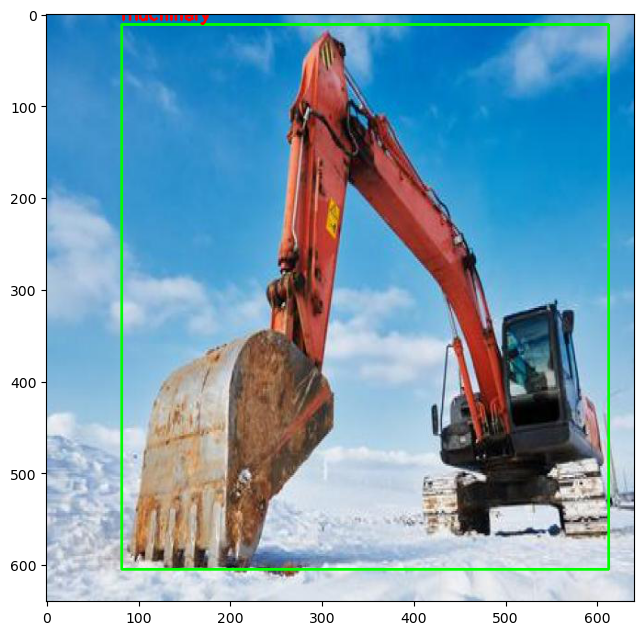

In [88]:
visualize_samples(mode = 'test', n_samples = 1)